## Time to get your hands dirty! Fun with Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import requests

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[6,5]

### Data

In [53]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in 
                     f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [54]:
print(data.shape)
print(names)
print(data[:,0])

(15, 8147)
['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']
['GRB230529A*' 'GRB230529330' '7:54:43.268' '346.8400' '-50.0000'
 '9.904024' '36.6080' '2.3600' '7:54:43.268' '2.0628e-06' '2.5536e-08'
 '-999' '36.6080' 'True' '60093.32966745']


In [127]:
ra = np.array(data[3], dtype=float)
decl = np.array(data[4], dtype=float)
pos_error = np.array(data[5], dtype=float)
T90 = np.array(data[6], dtype=float)
T90_error = np.array(data[7], dtype=float)
fluence = np.array(data[9], dtype=float)
fluence_error = np.array(data[10], dtype=float)
redshift = np.array(data[11], dtype=float)
T100=np.array(data[12], dtype=float)

### Functions

Define the function to get the right labels for the Gamma-Ray busts: $0$ for *short GRB* and $1$ for the *long GRB*.

In [5]:
def right_labels(data, labels, center):
    a = np.where(data == max(data))
    if (labels[a] == 0):
        center=center[::-1]
        for i in range(len(data)):# invert labels for each sample
            if labels[i] == 0:
                labels[i] = 1
            elif labels[i] == 1:
                labels[i] = 0
    return labels, center

def right_labels_gauss(data, labels):
    a = np.where(data == max(data))
    if (labels[a] == 0):
        for i in range(len(data)):# invert labels for each sample
            if labels[i] == 0:
                labels[i] = 1
            elif labels[i] == 1:
                labels[i] = 0
    return labels

### Duration

Consider first the duration of the GRB to observe if the distribution presents some kind of bimodality.

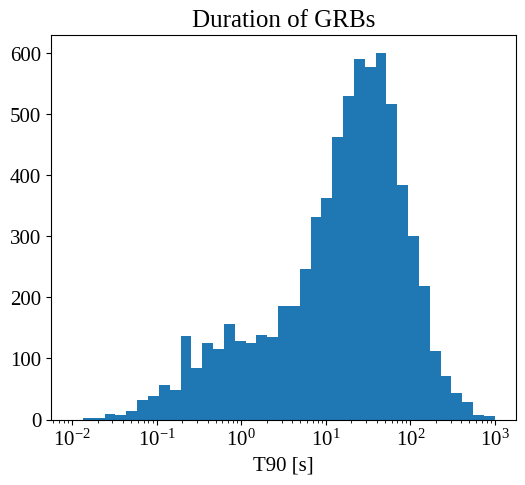

The number of the events is:  7124


In [147]:
mask_T90 = T90>0
plt.hist(T90[mask_T90], bins=np.logspace(-2, 3, 40))
plt.title('Duration of GRBs')
plt.semilogx()
plt.xlabel('T90 [s]')
plt.show()

print('The number of the events is: ', len(T90[mask_T90]))

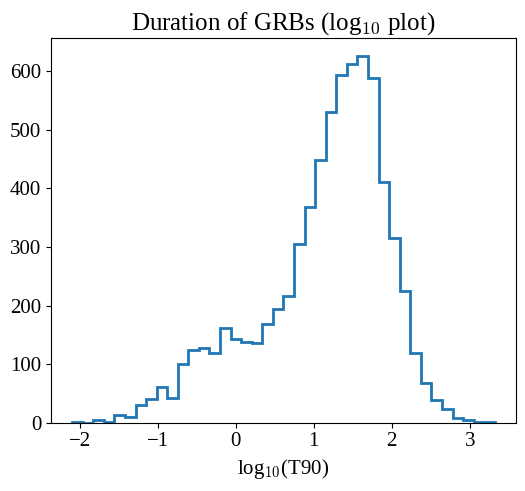

In [7]:
T90_cluster=np.log10(T90[mask_T90])

plt.hist(T90_cluster, bins=40, histtype='step', lw=2)
plt.title('Duration of GRBs (log$_{10}$ plot)')
plt.xlabel('log$_{10}$(T90)')
plt.show()

From the data we can observe that maybe there is the presence of two populations. Try some cluster algorithms to verify the presence of one or more cluster in the data.

### KMeans

Consider first KMeans and impose the number of cluster equal to $2$; let's try to verify if the result make sense.

In [8]:
km = KMeans(n_clusters=2)
km.fit(T90_cluster[:, np.newaxis])
KMcenters = km.cluster_centers_
kmlabels = km.predict(T90_cluster[:, np.newaxis])
kmlabels, KMcenters = right_labels(T90_cluster, kmlabels, KMcenters)

/home/sale/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


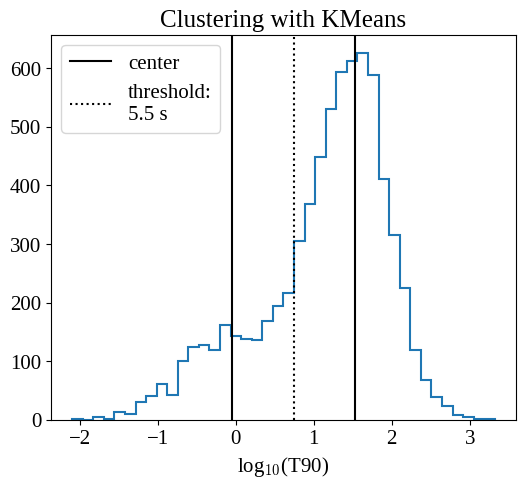

The centers of the two clusters are:  0.9 s and  33.6 s


In [137]:
KMshort = T90_cluster[kmlabels == 0]
KMlong = T90_cluster[kmlabels == 1]

KMthreshold = np.median([max(KMshort), min(KMlong)])

plt.hist(T90_cluster, bins=40, histtype='step', lw=1.5)
plt.title('Clustering with KMeans')
plt.xlabel('log$_{10}$(T90)')

plt.axvline(KMcenters[0],color='black', label='center')
plt.axvline(KMcenters[1],color='black')
plt.axvline(KMthreshold, color='black', linestyle='dotted', label = 'threshold:\n%s s' %round(10**KMthreshold,1))

plt.legend()
plt.show()

print('The centers of the two clusters are: ', round(10**KMcenters[0,0],1), 's and ', 
      round(10**KMcenters[1,0],1), 's')

This result is very important: in the GRB there is a bimodality. In particular there is a threshold at the order of some seconds ($5.5 s$ in this case) that separate two clusters. We can actually recognize the presence of two groups, called *Short GRB* and *Long GRB* based on the duration of the burst.

As a further verification of this result we can try to use others clustering algorithms.

### Mean-Shift

The advantage of this method is that we do not specify the number of the clusters, but this quantity is data-driven. Let's first estimate the optimal bandwidth of the algorithm and then run the clustering.

In [49]:
#try now mean-shift

bandwidth = estimate_bandwidth(T90_cluster[:,np.newaxis], n_jobs=-1)
print(bandwidth)

0.5202505116127759


In [19]:
scaler = preprocessing.StandardScaler()
ms = MeanShift(bandwidth=bandwidth, n_jobs=-1)
ms.fit(scaler.fit_transform(T90_cluster[:,np.newaxis]))

MeanShift(bandwidth=0.5202505116127759, n_jobs=-1)

In [20]:
MSlabels = ms.labels_
MScenters = scaler.inverse_transform(ms.cluster_centers_)
n_clusters = len(np.unique(MSlabels[MSlabels >= 0]))
print('bandwidth= ', round(bandwidth,3))
print("number of estimated clusters :", n_clusters)

MSlabels, MScenters = right_labels(T90_cluster, MSlabels, MScenters)

bandwidth=  0.52
number of estimated clusters : 2


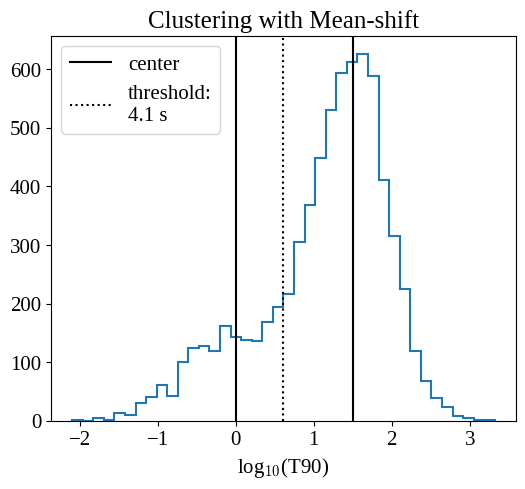

The centers of the two clusters are:  1.0 s and  31.9 s


In [138]:
plt.hist(T90_cluster, bins=40, histtype='step', lw=1.5)
plt.title('Clustering with Mean-shift')
plt.xlabel('log$_{10}$(T90)')

plt.axvline(MScenters[0],color='black', label='center')
plt.axvline(MScenters[1],color='black')

MSshort = T90_cluster[MSlabels == 1]
MSlong = T90_cluster[MSlabels == 0]

MSthreshold = np.median([max(MSshort), min(MSlong)])

plt.axvline(MSthreshold, color='black', linestyle='dotted', label = 'threshold:\n%s s' %round(10**MSthreshold,1))

plt.legend()
plt.show()

print('The centers of the two clusters are: ', round(10**MScenters[0,0],1), 's and ', round(10**MScenters[1,0],1), 
      's')

We estimated also in this case the presence of two clusters! And in particular the threshold and the centers of the two groups are very very similar. This is important because Mean-Shift estimate the number of the clusters directly from the data, without any *human* intervention.

As a further verification of the validity of this result we can use a gaussian mixture model to fit the data.

### Gaussian mixture

By considering the gaussian mixture model, we can estimate the number of the gaussian distributions that better fit the data. This will also be the number of the estimated clusters.

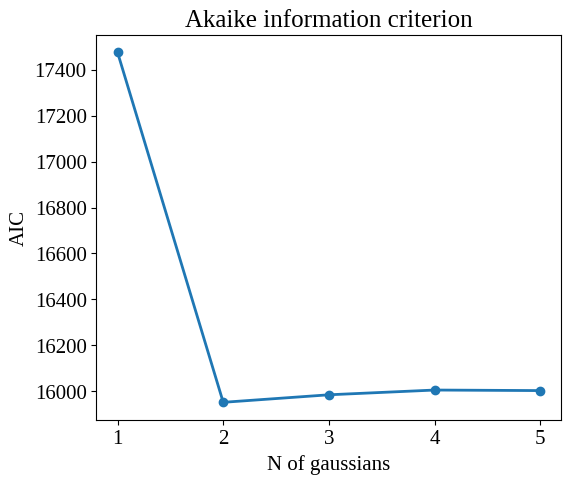

The best model is the one with  2  components


In [23]:
#let's try to use a gaussia mixture to find out if our data are described by 2 gaussian
components=np.linspace(1,5,5, dtype=int)

gm = np.array([GaussianMixture(n_components=c).fit(T90_cluster[:,np.newaxis]) for c in components])

#compute the AIC and plot its values as a function of the number of the gaussian
AIC=np.empty(len(components))
for i in range(len(components)):
    AIC[i] = gm[i].aic(T90_cluster[:,np.newaxis])
    
plt.plot(components, AIC, lw=2)
plt.scatter(components, AIC)
plt.ylabel('AIC')
plt.xlabel('N of gaussians')
plt.title('Akaike information criterion')
plt.show()

min_i=np.argmin(AIC)
best_model=components[min_i]

print("The best model is the one with ", best_model, " components")

The best model is the one that it is described by $2$ gaussian distributions. Let's observe how this model fits the data.

GaussianMixture(n_components=2)


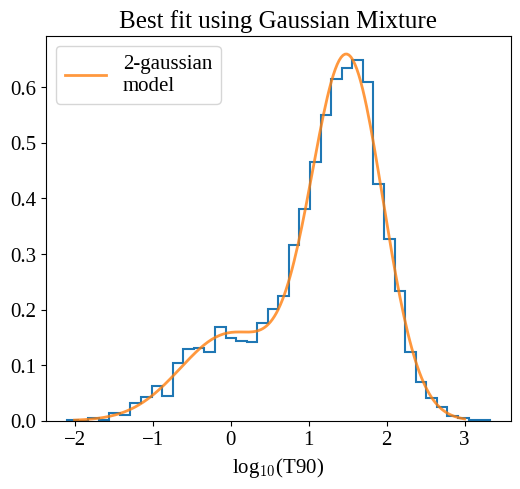

In [24]:
#plot now the fit, to visually verify its correctness

best_model=gm[min_i]
print(best_model)

plt.hist(T90_cluster, bins=40, histtype='step', density=True, lw=1.5)
plt.title('Best fit using Gaussian Mixture')
plt.xlabel('log$_{10}$(T90)')

xgrid=np.linspace(-2, 3, 200)

plt.plot(xgrid, np.exp(best_model.score_samples(xgrid[:, np.newaxis])), lw=2, label='2-gaussian\nmodel', alpha=0.8)
plt.legend()
plt.show()

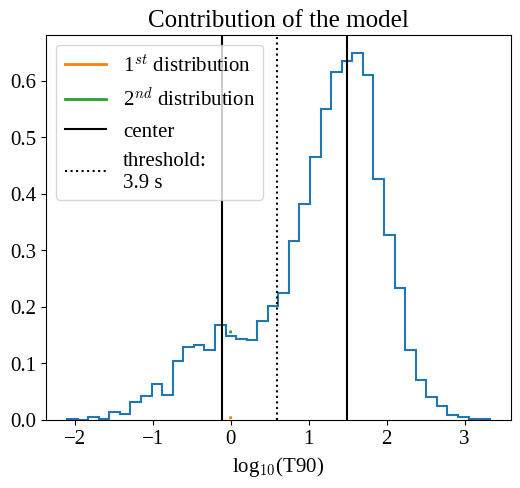

The centers of the two clusters are:  0.8 s and  30.9 s


In [140]:
#plot the contribution of each gaussian distribution

contr=best_model.predict_proba(xgrid[:, np.newaxis])
pdf=np.exp(best_model.score_samples(xgrid[:, np.newaxis]))
pdf_contr=contr*pdf[:, np.newaxis]

gmlabels = best_model.predict(T90_cluster[:, np.newaxis])

gmlabels = right_labels_gauss(T90_cluster, gmlabels)

GMshort = T90_cluster[gmlabels == 0]
GMlong = T90_cluster[gmlabels == 1]

GMthreshold = np.median([max(GMshort), min(GMlong)])
GMcenters = [np.median(GMshort), np.median(GMlong)]

plt.hist(T90_cluster, bins=40, histtype='step', density=True, lw=1.5)

plt.plot(xgrid, pdf_contr[:,0], lw=2, label='1$^{st}$ distribution')
plt.plot(xgrid, pdf_contr[:,1], lw=2, label='2$^{nd}$ distribution')
plt.xlabel('log$_{10}$(T90)')
plt.title('Contribution of the model')

plt.axvline(GMcenters[0],color='black', label='center')
plt.axvline(GMcenters[1],color='black')

plt.axvline(GMthreshold, color='black', linestyle='dotted', label = 'threshold:\n%s s' %round(10**GMthreshold,1))

plt.legend()
plt.show()

print('The centers of the two clusters are: ', round(10**GMcenters[0],1), 's and ', round(10**GMcenters[1],1), 's')

Also with this method we find results that are very similar to the other algorithms, in particular the centers and the threshold are very similar to what we have already found.

### Comparison of the results

We found results that are very similar to each other. Consider a recap of what we found.

In [142]:
#comparison between the three models
#compare the threshold

print('Threshold found with: \n KMeans: ', round(10**KMthreshold,1), 's\n Mean-Shift: ', round(10**MSthreshold,1), 
      's\n Gaussian Mixture:', round(10**GMthreshold,1), 's')

print('\nCenters of the two groups (Short GRB and Long GRB): \n KMeans:', round(10**KMcenters[0,0],1), 's and ', 
      round(10**KMcenters[1,0],1), 's\n Mean-Shift: ', round(10**MScenters[0,0],1), 's and ', 
      round(10**MScenters[1,0],1), 's\n Gaussian Mixture:', round(10**GMcenters[0],1), 's and ', 
      round(10**GMcenters[1],1), 's')

Threshold found with: 
 KMeans:  5.5 s
 Mean-Shift:  4.1 s
 Gaussian Mixture: 3.9 s

Centers of the two groups (Short GRB and Long GRB): 
 KMeans: 0.9 s and  33.6 s
 Mean-Shift:  1.0 s and  31.9 s
 Gaussian Mixture: 0.8 s and  30.9 s


This is a splendid result! We found the presence of two clusters based on the duration of the Gamma-Ray bursts, with a threshold located at about $3$-$5s$ and the centers at about $1s$ and $32s$. The separation into *Short* and *Long* GRB seems to make sense.

But is the duration the only quantity that presents this bimodality?

### Fluence

Consider the flunece of the signals. First have a quick exploration of the data.

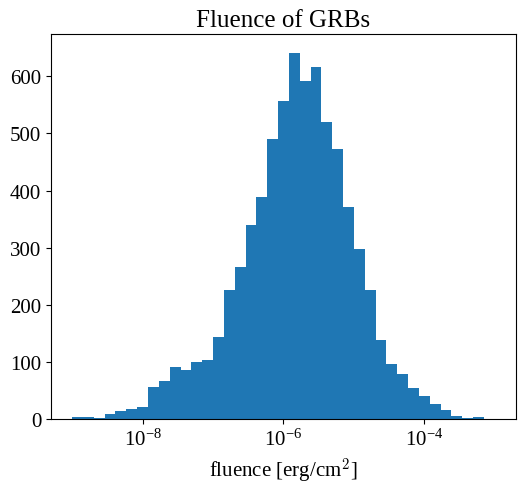

In [132]:
#other variables show this bimodality?

mask_f = fluence>0
mask_Tf=np.logical_and(T90>0, fluence>0)

plt.hist(fluence[mask_f], bins=np.logspace(-9, -3, 40))
plt.title('Fluence of GRBs')
plt.semilogx()
plt.xlabel('fluence [erg/cm$^2$]')
plt.show()

It seems that also in this case we have the presence of two clusters. Let's try to consider together the duration and the fluence of the GRB.

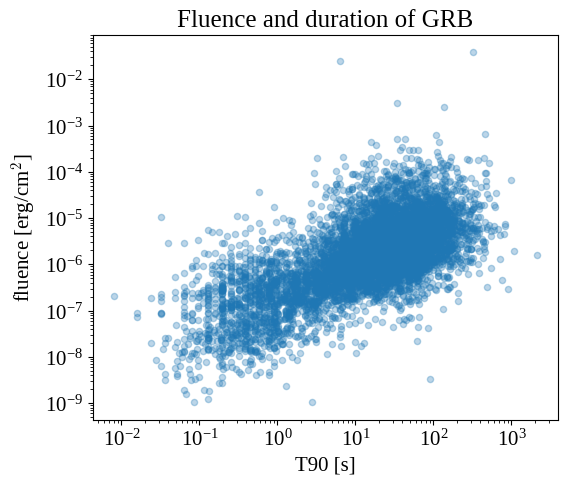

In [131]:
plt.scatter(T90[mask_Tf], fluence[mask_Tf], alpha=0.3, s=20)
plt.semilogx()
plt.semilogy()
plt.title('Fluence and duration of GRB')
plt.xlabel('T90 [s]')
plt.ylabel('fluence [erg/cm$^2$]')

plt.show()

Try a two dimensional clustering to verify the presence of the two custers.

In [29]:
T90_2d=np.log10(T90[mask_Tf])
fluence_2d=np.log10(fluence[mask_Tf])

X = np.concatenate([T90_2d[:,np.newaxis],fluence_2d[:,np.newaxis]], axis=1)

km_2d = KMeans(n_clusters=2) #Try 2 clusters to start with
km_2d.fit(X)
KMcenters_2d = km_2d.cluster_centers_ #location of the clusters
KMlabels_2d = km_2d.predict(X)

/home/sale/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


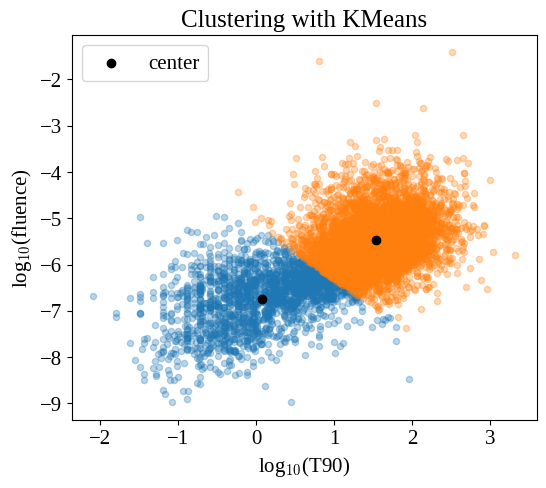

The centers of the two clusters are:
 T90= 1.2 s and fluence= 1.8e-07 erg/cm2 
 T90= 34.1 s and fluence= 3.4e-06 erg/cm2


In [30]:
for ii in range(2):
    plt.scatter(X[KMlabels_2d==ii,0], X[KMlabels_2d==ii,1], alpha=0.3, s=20)
    
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')
plt.title('Clustering with KMeans')

plt.scatter(KMcenters_2d[0,0], KMcenters_2d[0,1], label='center', c='black')
plt.scatter(KMcenters_2d[1,0], KMcenters_2d[1,1], c='black')

plt.legend()
plt.show()

print('The centers of the two clusters are:\n T90=', round(10**KMcenters_2d[0,0],1), 's and fluence=', 
      round(10**KMcenters_2d[0,1],8), 'erg/cm2 \n T90=', round(10**KMcenters_2d[1,0],1), 's and fluence=', 
      round(10**KMcenters_2d[1,1],7), 'erg/cm2')

With KMeans, by imposing the presence of $2$ clusters, we are able to find a reasonable resut. But consider now Mean-Shift.

In [50]:
#try Mean-shift

bandwidth_2d = estimate_bandwidth(X, n_jobs=-1)
print(bandwidth_2d)

0.9192246390018368


In [33]:
scaler = preprocessing.StandardScaler()
ms_2d = MeanShift(bandwidth=bandwidth_2d, n_jobs=-1)
ms_2d.fit(scaler.fit_transform(X))

MeanShift(bandwidth=0.9192246390018368, n_jobs=-1)

In [34]:
MSlabels_2d = np.unique(ms_2d.labels_)
n_clusters_2d = len(MSlabels_2d[MSlabels_2d >= 0])
print(MSlabels_2d)
print('bandwidth= ', round(bandwidth_2d,3))
print("number of estimated clusters :", n_clusters_2d)

[0 1 2 3]
bandwidth=  0.919
number of estimated clusters : 4


This time the algorithm estimated the presence of $4$ clusters, which doesn't agree with what we expect. Let's observe the distributions of these $4$ clusters.

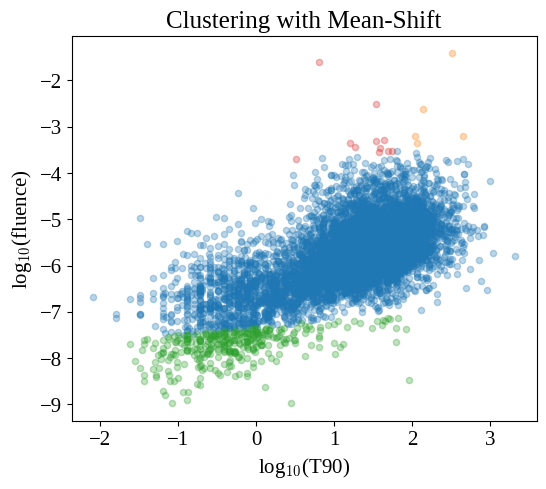

In [35]:
#4 clusters!

for ii in range(4):
    plt.scatter(X[ms_2d.labels_==ii,0], X[ms_2d.labels_==ii,1], alpha=0.3, s=20)
    
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')
plt.title('Clustering with Mean-Shift')

plt.show()

This result doesn't seem to make much sense! Maybe we can try to increase a bit the value of the bandwidth, to try to decrease the numbers of the clusters.

In [37]:
#try to increase the value of the bandwidth to try to absorb the 2 small clusters

scaler = preprocessing.StandardScaler()
ms_2d_2 = MeanShift(bandwidth=bandwidth_2d*1.6, n_jobs=-1)
ms_2d_2.fit(scaler.fit_transform(X))

MeanShift(bandwidth=1.470759422402939, n_jobs=-1)

In [38]:
MSlabels_2d_2 = np.unique(ms_2d_2.labels_)
n_clusters_2d_2 = len(MSlabels_2d_2[MSlabels_2d_2 >= 0])
print(MSlabels_2d_2)
print('bandwidth= ', round(bandwidth_2d*1.6,3))
print("number of estimated clusters :", n_clusters_2d_2)

[0 1]
bandwidth=  1.471
number of estimated clusters : 2


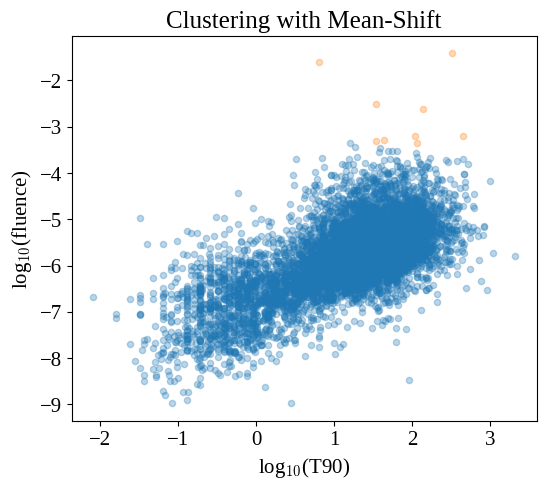

In [39]:
for ii in range(2):
    plt.scatter(X[ms_2d_2.labels_==ii,0], X[ms_2d_2.labels_==ii,1], alpha=0.3, s=20)
    
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')
plt.title('Clustering with Mean-Shift')

plt.show()

We actually estimated the presence of two clusters, but the result still doesn't seem to make much sense. We can try to rescale the data if the fluence with an *arctan* function, this in principle would allow to compress the distribution to help the algorithm.

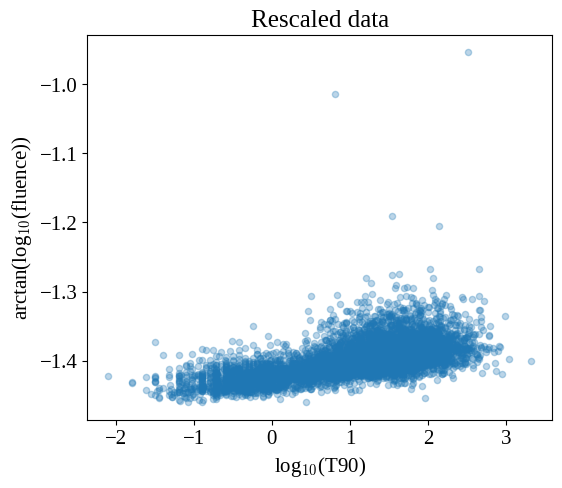

In [40]:
#try to rescale the data as arctan(X)

X_scale = np.concatenate([T90_2d[:,np.newaxis],np.arctan(fluence_2d[:,np.newaxis])], axis=1)
plt.scatter(X_scale[:,0], X_scale[:,1], alpha=0.3, s=20)

plt.xlabel('log$_{10}$(T90)')
plt.ylabel('arctan(log$_{10}$(fluence))')
plt.title('Rescaled data')

plt.show()

In [41]:
bandwidth_2d_s = estimate_bandwidth(X_scale, n_jobs=-1)
print(bandwidth_2d_s)

0.5179348085158902


In [42]:
scaler = preprocessing.StandardScaler()
ms_2d_s = MeanShift(bandwidth=bandwidth_2d_s*2, n_jobs=-1)
ms_2d_s.fit(scaler.fit_transform(X_scale))

MeanShift(bandwidth=1.0358696170317805, n_jobs=-1)

In [43]:
MSlabels_2d_s = np.unique(ms_2d_s.labels_)
n_clusters_2d_s = len(np.unique(MSlabels_2d_s[MSlabels_2d_s >= 0]))
print(MSlabels_2d_s)
print('bandwidth= ', round(bandwidth_2d_s,3))
print("number of estimated clusters :", n_clusters_2d_s)

[0 1 2 3]
bandwidth=  0.518
number of estimated clusters : 4


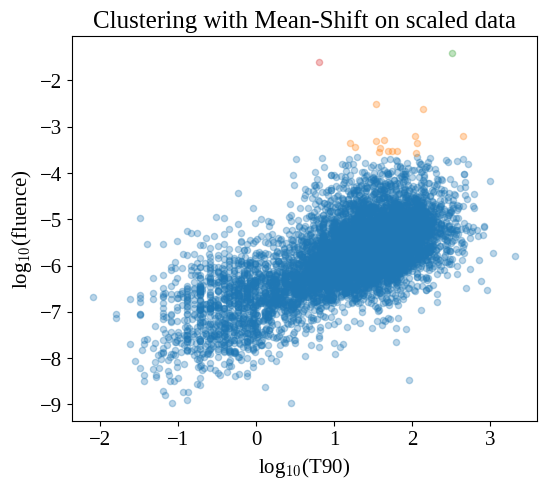

In [44]:
for ii in range(n_clusters_2d_s):
    plt.scatter(X[ms_2d_s.labels_==ii,0], X[ms_2d_s.labels_==ii,1], alpha=0.3, s=20)
    
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')
plt.title('Clustering with Mean-Shift on scaled data')

plt.show()

But we didn't get any improvement of the clustering. Maybe let's try to change method.

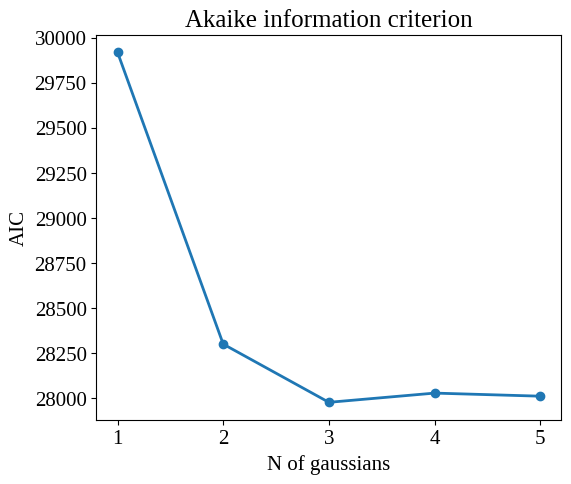

The best model is the one with  3  components


In [45]:
#try gaussian mixture

components=np.linspace(1,5,5, dtype=int)

gm_2d = np.array([GaussianMixture(n_components=c).fit(X) for c in components])

#compute the AIC and plot its values as a function of the number of the gaussian
AIC=np.empty(len(components))
for i in range(len(components)):
    AIC[i] = gm_2d[i].aic(X)
    
plt.plot(components, AIC, lw=2)
plt.scatter(components, AIC)
plt.ylabel('AIC')
plt.xlabel('N of gaussians')
plt.title('Akaike information criterion')
plt.show()

min_i=np.argmin(AIC)
best_model_c=components[min_i]

print("The best model is the one with ", best_model_c, " components")

GaussianMixture(n_components=3)


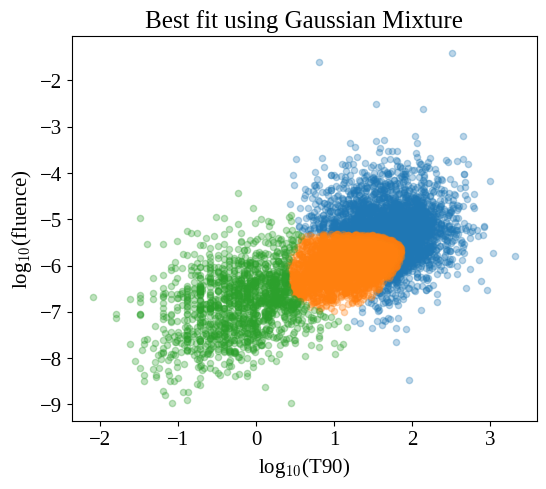

In [46]:
best_model_2d=gm_2d[min_i]
print(best_model_2d)

GMlabels_2d = best_model_2d.predict(X)

for ii in range(best_model_c):
    plt.scatter(X[GMlabels_2d==ii,0], X[GMlabels_2d==ii,1], alpha=0.3, s=20)

plt.title('Best fit using Gaussian Mixture')
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')

plt.show()

The best model predict the presence of three gaussians, from the plot it seems that there is the presence of an additional cluster in the middle. Let's try to force the presence of only two gaussians.

GaussianMixture(n_components=2)


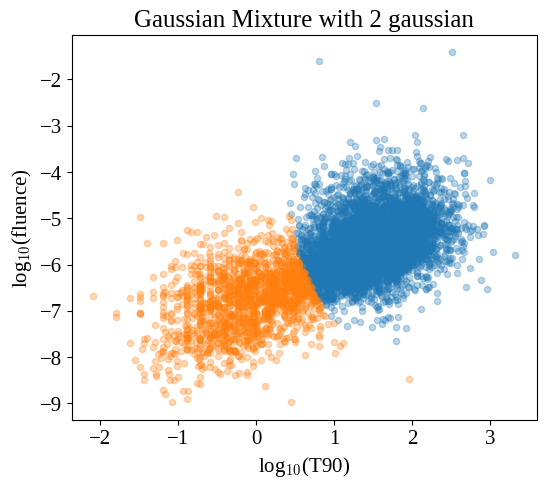

In [47]:
#force two gaussians

GM_2g_model=gm_2d[1]
print(GM_2g_model)

GMlabels_2d_2 = GM_2g_model.predict(X)

for ii in range(2):
    plt.scatter(X[GMlabels_2d_2==ii,0], X[GMlabels_2d_2==ii,1], alpha=0.3, s=20)

plt.title('Gaussian Mixture with 2 gaussian')
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')

plt.show()

In this case the result seems to make sense, it is similar to what we found with KMeans.

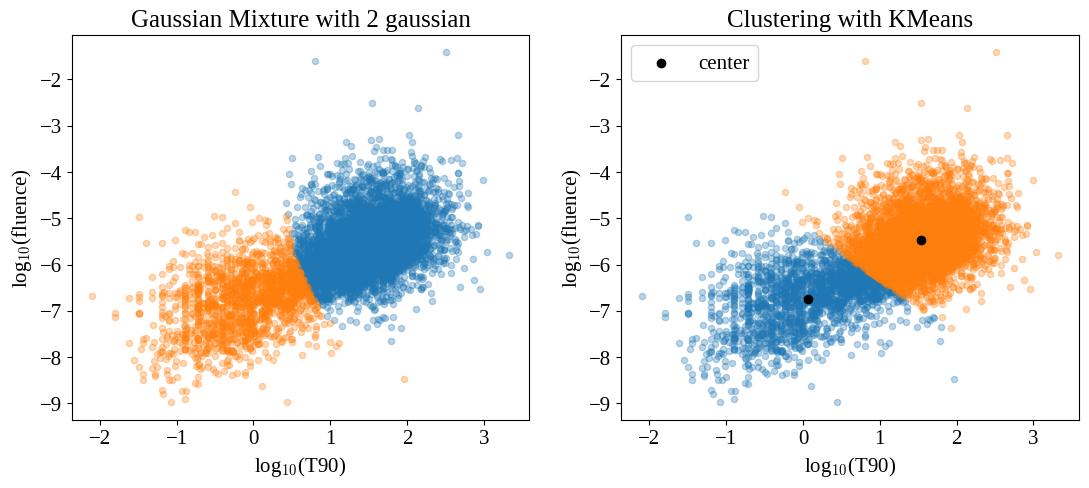

In [143]:
fig = plt.figure(figsize=(13, 5))

ax=fig.add_subplot(121)

for ii in range(2):
    plt.scatter(X[GMlabels_2d_2==ii,0], X[GMlabels_2d_2==ii,1], alpha=0.3, s=20)

plt.title('Gaussian Mixture with 2 gaussian')
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')

ax=fig.add_subplot(122)

for ii in range(2):
    plt.scatter(X[KMlabels_2d==ii,0], X[KMlabels_2d==ii,1], alpha=0.3, s=20)
    
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')
plt.title('Clustering with KMeans')

plt.scatter(KMcenters_2d[0,0], KMcenters_2d[0,1], label='center', c='black')
plt.scatter(KMcenters_2d[1,0], KMcenters_2d[1,1], c='black')

plt.legend()
plt.show()

### Redshift

Let's consider now the redshift of the events.

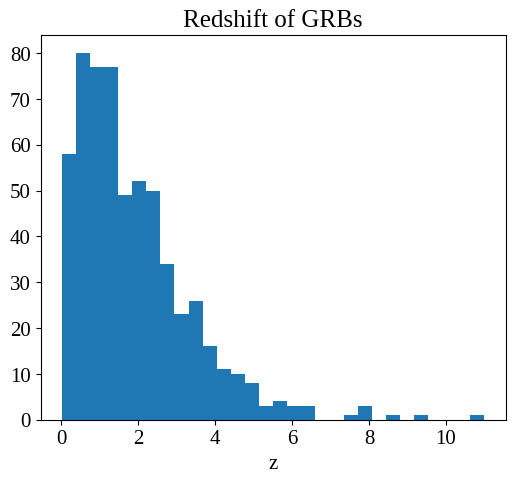

The number of events that provides also a measurment of the redshift is:  591


In [146]:
# Distribution of the redshift

mask_z = redshift>0
plt.hist(redshift[mask_z], bins=30)
plt.title('Redshift of GRBs')
plt.xlabel('z')
plt.show()

print('The number of events that provides also a measurment of the redshift is: ', len(redshift[mask_z]))

We have only a small amount of data, but maybe we can infer some additional information on the nature of the Gamma-Ray busts. In particular consider the two groups that we found before (*Long* and *Short* GRB) and for simplicity assume as the threshold of the two clusters the limit that we found with the Gaussian Mixture algorithm.

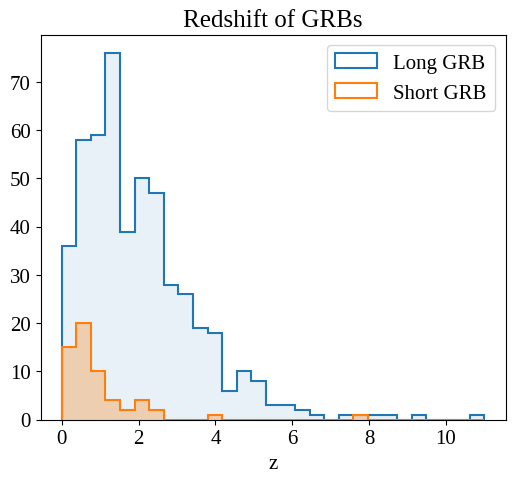

Number of data
 Short GRB:  59  ( 3.7 % of the total)
 Long GRB:  495  ( 8.9 % of the total)


In [102]:
#Consider the gaussin mixture threshold to observe the distribution in redshit of the short and long GRB

trs=10**GMthreshold

mask_short=np.logical_and(np.logical_and(T90>0, T90<trs), redshift>0)
mask_long=np.logical_and(T90>trs, redshift>0)

bins=np.linspace(0,11,30)

plt.hist(redshift[mask_long], bins=bins, histtype='step', lw=1.5, color='C0', label='Long GRB')
plt.hist(redshift[mask_long], bins=bins, alpha=0.1, color='C0')

plt.hist(redshift[mask_short], bins=bins, histtype='step', lw=1.5, color='C1', label='Short GRB')
plt.hist(redshift[mask_short], bins=bins, alpha=0.3, color='C1')

plt.title('Redshift of GRBs')
plt.xlabel('z')
plt.legend()
plt.show()

frac_short=len(redshift[mask_short])/len(T90[np.logical_and(T90>0, T90<trs)])*100
frac_long=len(redshift[mask_long])/len(T90[T90>trs])*100

print('Number of data\n Short GRB: ', len(redshift[mask_short]),' (',  round(frac_short,1),
      '% of the total)\n Long GRB: ', len(redshift[mask_long]), ' (',  round(frac_long,1), '% of the total)')

despite the presence of a little amount of data, we can begin to observe how it would appear that *short GRB* are only generated at low redshift (up to $z\simeq3$), while long GRBs would appear to be generated at both low and higher redshift. But this distribution may be subject to selection effects.

### Positions

Just for verification we can observe the spatial distribution of Gamma-Ray bursts. In general we expect both *Long* and *Short* GRB to be isotropically distributed, With no preference for either *short* or *long*.

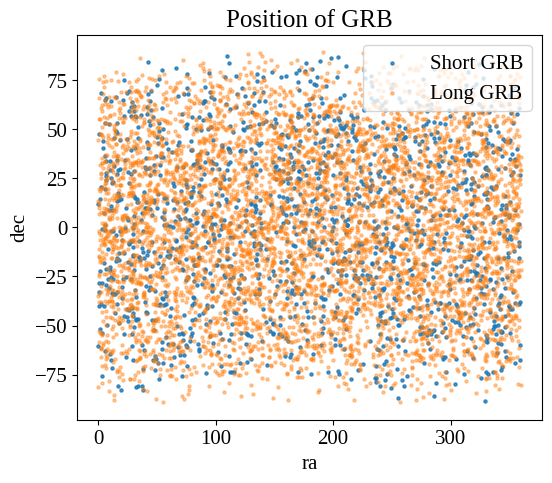

In [126]:
plt.scatter(ra[np.logical_and(T90>0, T90<trs)], decl[np.logical_and(T90>0, T90<trs)], s=5, 
            alpha=0.8, label='Short GRB')
plt.scatter(ra[T90>trs], decl[T90>trs], s=5, alpha=0.4, label='Long GRB')

plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Position of GRB')
plt.legend()
plt.show()

It seems that all the events are equally distributed in the sky.

### Errors

In our analysis we didn't consider the errors, but is this a good approximation? Or maybe we need to perform a deeper investigation.

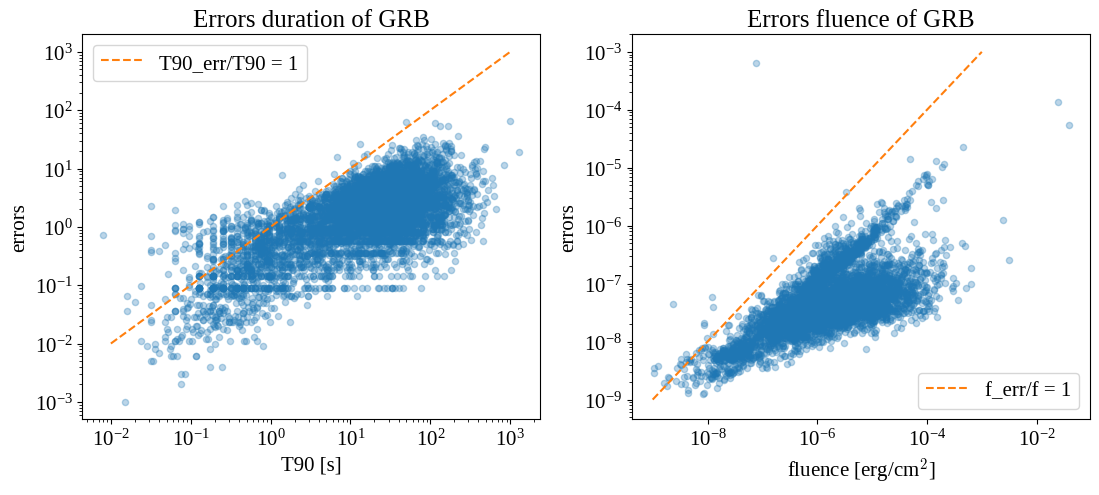

In [145]:
mask_Terr=np.logical_and(T90>0, T90_error>0)

mask_ferr=np.logical_and(fluence>0, fluence_error>0)

fig = plt.figure(figsize=(13, 5))

ax=fig.add_subplot(121)

plt.scatter(T90[mask_Terr], T90_error[mask_Terr], alpha=0.3, s=20)
plt.semilogx()
plt.semilogy()
plt.title('Errors duration of GRB')
plt.xlabel('T90 [s]')
plt.ylabel('errors')
xgrid=np.logspace(-2,3,4)
plt.plot(xgrid,xgrid, c='C1', ls='--', label='T90_err/T90 = 1')
plt.legend()

ax=fig.add_subplot(122)

plt.scatter(fluence[mask_Terr], fluence_error[mask_Terr], alpha=0.3, s=20)
plt.semilogx()
plt.semilogy()
plt.title('Errors fluence of GRB')
plt.xlabel('fluence [erg/cm$^2$]')
plt.ylabel('errors')
xgrid=np.logspace(-9,-3,4)
plt.plot(xgrid,xgrid, c='C1', ls='--', label='f_err/f = 1')
plt.legend()

plt.show()

If we consider the flunece, in general the errors are smaller than the value of the data. But if we consider the duration, and in particular for the shortest events, there are some events with an error greater than the signal itself.